In [8]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
request_data = {
    "totalResource": {
        "GPU": 100,
        "CPU": 16000,
        "Memory": 32000000
    },
    "totalUsage": {
        "GPU": 100,
        "CPU": 1000,
        "Memory": 10000000
    },
    "k": 1,
    "queues": [
        {
            "uid": "queue1",
            "name": "test-queue",
            "priority": 0,
            "resourceShare": {
                "gpu": {
                    "deserved": 10,
                    "request": 100,
                    "overQuotaWeight": 3,
                    "absoluteUsage": 75
                }
            }
        },
        {
            "uid": "queue2",
            "name": "test-queue2",
            "priority": 0,
            "resourceShare": {
                "gpu": {
                    "deserved": 10,
                    "request": 100,
                    "overQuotaWeight": 1,
                    "absoluteUsage": 0
                }
            }
        }
    ]
}


In [10]:
# API endpoint
url = "http://localhost:8080/simulate"

# Headers
headers = {
    "Content-Type": "application/json"
}

# Make the POST request
try:
    response = requests.post(url, json=request_data, headers=headers)
    response.raise_for_status()  # Raise an exception for bad status codes
    
    # Parse and display the response
    result = response.json()
    print("Fairshare simulation results:")
    print(json.dumps(result, indent=2))
    
except requests.exceptions.RequestException as e:
    print(f"Error making request: {e}")
except json.JSONDecodeError as e:
    print(f"Error parsing response: {e}")


Fairshare simulation results:
{
  "queue1": {
    "gpu": 58,
    "cpu": 16000,
    "memory": 100000
  },
  "queue2": {
    "gpu": 42,
    "cpu": 16000,
    "memory": 100000
  }
}


In [11]:
try:
    print("Queue Analysis:")
    print("-" * 40)
    
    for queue_id, shares in result.items():
        print(f"Queue: {queue_id}")
        print(f"GPU Fairshare: {shares['gpu']:.2f}")
        print(f"CPU Fairshare: {shares['cpu']:.2f}")
        print(f"Memory Fairshare: {shares['memory']:.2f}")
        print("-" * 40)
        
except NameError:
    print("No results to analyze. Make sure the API request was successful.")


Queue Analysis:
----------------------------------------
Queue: queue1
GPU Fairshare: 58.00
CPU Fairshare: 16000.00
Memory Fairshare: 100000.00
----------------------------------------
Queue: queue2
GPU Fairshare: 42.00
CPU Fairshare: 16000.00
Memory Fairshare: 100000.00
----------------------------------------


In [12]:
def run_fairshare_simulation(k_value=1, queue1_weight=3, queue2_weight=1):
    """
    Run fairshare simulation with configurable parameters.
    
    Args:
        k_value (float): The k value for the fairshare calculation
        queue1_weight (float): Over-quota weight for queue1's GPU
        queue2_weight (float): Over-quota weight for queue2's GPU
        
    Returns:
        pandas.DataFrame: DataFrame containing simulation results
    """
    # Create base request data
    sim_request = {
        "totalResource": {
            "GPU": 100,
            "CPU": 16000,
            "Memory": 32000000
        },
        "totalUsage": {
            "GPU": 100,
            "CPU": 1000,
            "Memory": 10000000
        },
        "k": k_value,
        "queues": [
            {
                "uid": "queue1",
                "name": "test-queue",
                "priority": 0,
                "resourceShare": {
                    "gpu": {
                        "deserved": 0,
                        "request": 100,
                        "overQuotaWeight": queue1_weight,
                        "absoluteUsage": 0  # Will be updated in loop
                    }
                }
            },
            {
                "uid": "queue2",
                "name": "test-queue2",
                "priority": 0,
                "resourceShare": {
                    "gpu": {
                        "deserved": 0,
                        "request": 100,
                        "overQuotaWeight": queue2_weight,
                        "absoluteUsage": 0
                    }
                }
            }
        ]
    }
    
    # Initialize lists to store results
    iterations = []
    queue1_fairshare = []
    queue2_fairshare = []
    
    # Simulate for different usage values
    for i in range(120):
        # Update queue1's GPU usage for this iteration
        sim_request['queues'][0]['resourceShare']['gpu']['absoluteUsage'] = i
        
        try:
            response = requests.post(url, json=sim_request, headers=headers)
            response.raise_for_status()
            result = response.json()
            
            # Store results
            iterations.append(i)
            queue1_fairshare.append(result['queue1']['gpu'])
            queue2_fairshare.append(result['queue2']['gpu'])
            
        except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
            print(f"Error at iteration {i}: {e}")
            break
    
    # Create and return a pandas DataFrame
    return pd.DataFrame({
        'iteration': iterations,
        'queue1_gpu_fair_share': queue1_fairshare,
        'queue2_gpu_fair_share': queue2_fairshare
    })


In [13]:
def plot_fairshare_simulation(df, k_value, queue1_weight, queue2_weight, figsize=(12, 6), show_data=True):
    """
    Plot fairshare values from a simulation DataFrame.
    
    Args:
        df: pandas DataFrame with columns 'iteration', 'queue1_gpu_fair_share', 'queue2_gpu_fair_share'
        k_value: The k value used in the simulation
        queue1_weight: Over-quota weight for queue1's GPU
        queue2_weight: Over-quota weight for queue2's GPU
        figsize: tuple of (width, height) for the plot
        show_data: bool, whether to print the first few rows of data
    """
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot both queues' fairshare values
    plt.plot(df['iteration'], df['queue1_gpu_fair_share'], 
             label=f'Queue 1 (weight={queue1_weight})', marker='o', markersize=3)
    plt.plot(df['iteration'], df['queue2_gpu_fair_share'], 
             label=f'Queue 2 (weight={queue2_weight})', marker='o', markersize=3)
    
    # Customize the plot
    plt.title(f'GPU Fairshare Values vs Queue 1 Usage\n(k={k_value}, weights: q1={queue1_weight}, q2={queue2_weight})')
    plt.xlabel('Queue 1 GPU Usage')
    plt.ylabel('Fairshare Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Optionally display the first few rows of the data
    if show_data:
        print("\nFirst few rows of the simulation data:")
        print(df.head())


Running simulation with default parameters...


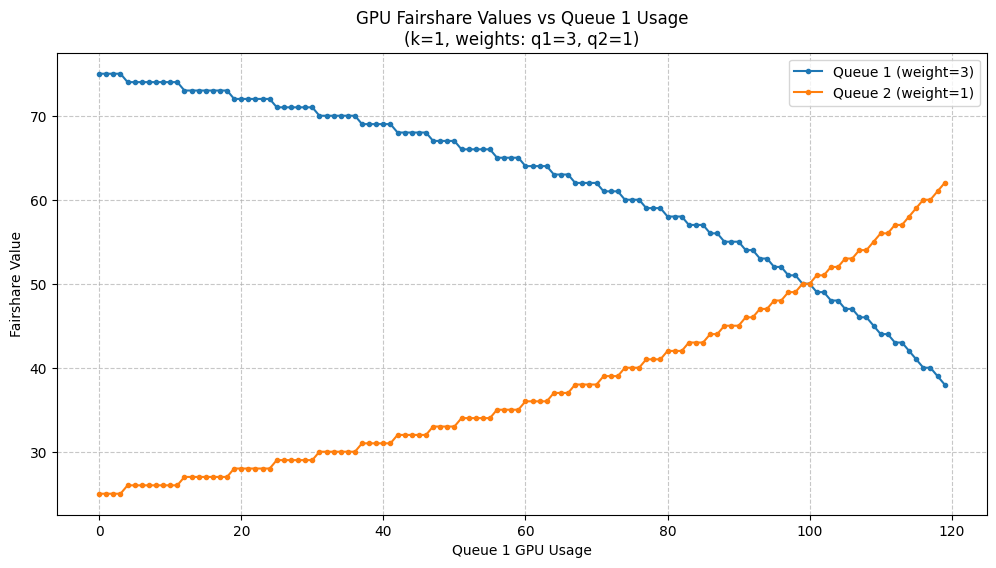


First few rows of the simulation data:
   iteration  queue1_gpu_fair_share  queue2_gpu_fair_share
0          0                     75                     25
1          1                     75                     25
2          2                     75                     25
3          3                     75                     25
4          4                     74                     26

Running simulation with k=1000...


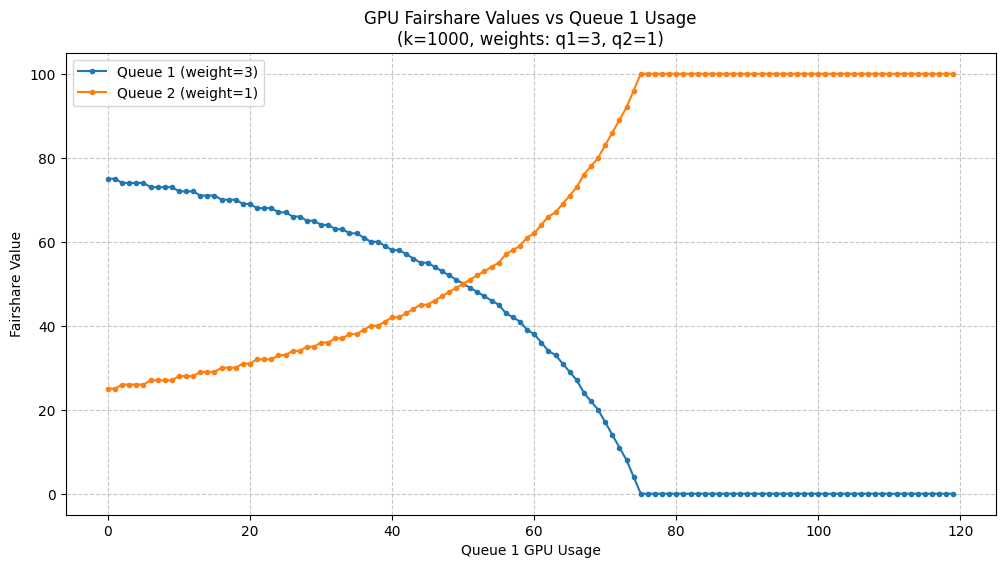


First few rows of the simulation data:
   iteration  queue1_gpu_fair_share  queue2_gpu_fair_share
0          0                     75                     25
1          1                     75                     25
2          2                     74                     26
3          3                     74                     26
4          4                     74                     26

Running simulation with equal weights...


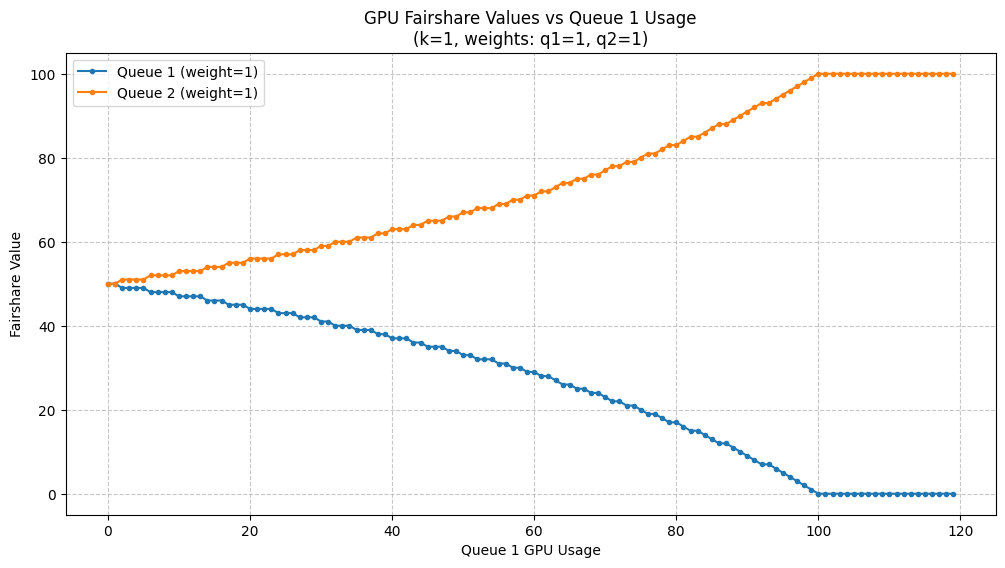


First few rows of the simulation data:
   iteration  queue1_gpu_fair_share  queue2_gpu_fair_share
0          0                     50                     50
1          1                     50                     50
2          2                     49                     51
3          3                     49                     51
4          4                     49                     51


In [14]:
# Run simulation with default parameters (k=1, queue1_weight=3, queue2_weight=1)
print("Running simulation with default parameters...")
k, q1w, q2w = 1, 3, 1
df_default = run_fairshare_simulation(k_value=k, queue1_weight=q1w, queue2_weight=q2w)
plot_fairshare_simulation(df_default, k_value=k, queue1_weight=q1w, queue2_weight=q2w)

# Run simulation with higher k value
print("\nRunning simulation with k=1000...")
k, q1w, q2w = 1000, 3, 1
df_high_k = run_fairshare_simulation(k_value=k, queue1_weight=q1w, queue2_weight=q2w)
plot_fairshare_simulation(df_high_k, k_value=k, queue1_weight=q1w, queue2_weight=q2w)

# Run simulation with equal weights
print("\nRunning simulation with equal weights...")
k, q1w, q2w = 1, 1, 1
df_equal = run_fairshare_simulation(k_value=k, queue1_weight=q1w, queue2_weight=q2w)
plot_fairshare_simulation(df_equal, k_value=k, queue1_weight=q1w, queue2_weight=q2w)